# Trabajo Práctico Nº2

**Integrantes**:
- Santiago Belen. 

**Objetivos**:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: *focus_video.mov*.
1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper *Image Sharpness Measure for Blurred Images in Frequency Domain* y realizar tres experimentos:
- Medición sobre todo el frame.
- Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.
- Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3).
    
Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
- Video con la ROI o matriz,  graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [2]:
#Funciones ROI
# Obtener una región de interés (ROI) de una imagen
def obtener_roi(frame, percentage=1.0):
    h, w = frame.shape[:2]
    roi_size = int(h * percentage), int(w * percentage)
    start = (h - roi_size[0]) // 2, (w - roi_size[1]) // 2
    return frame[start[0]:start[0] + roi_size[0], start[1]:start[1] + roi_size[1]]

# Dibujar el ROI en la imagen
def grafico_roi(frame, percentage=0.5, in_focus=False):
    h, w = frame.shape[:2]
    roi_size = int(h * percentage), int(w * percentage)
    start = (h - roi_size[0]) // 2, (w - roi_size[1]) // 2
    color = (0, 255, 0) if in_focus else (0, 0, 255)
    label = f'ROI {percentage * 100:.2g}%'
    cv.rectangle(frame, (start[1], start[0]), (start[1] + roi_size[1], start[0] + roi_size[0]), color, 2)
    return frame

# Carpeta de salida
output_dir = './Output'
os.makedirs(output_dir, exist_ok=True)

In [3]:
#Funciones Metricas
# Calcular la métrica de nitidez usando la transformada de Fourier
def sharpness_metric(frames, percentage=1.0):
    metrics = []
    for frame in frames:
        roi = obtener_roi(frame, percentage)
        gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
        af = np.abs(np.fft.fftshift(np.fft.fft2(gray)))
        metrics.append(np.sum(af >= np.max(af) / 1000) / (gray.shape[0] * gray.shape[1]))
    return metrics


# Calcular la métrica de nitidez usando el método Laplaciano
def laplacian_sharpness_metric(frames, percentage=1.0):
    metrics = []
    for frame in frames:
        roi = obtener_roi(frame, percentage)
        gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
        metrics.append(np.sum(cv.Laplacian(gray, cv.CV_64F)**2))
    return metrics


In [4]:
# Funciones de video
# Crear un video a partir de una lista de cuadros de imagen
def crear_video(frames, output_file, fps=30):
    h, w = frames[0].shape[:2]
    out = cv.VideoWriter(output_file, cv.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
    for frame in frames:
        out.write(frame)
    out.release()

# Obtener un cuadro de imagen específico de un video
def obtener_frame(video, index):
    video.set(cv.CAP_PROP_POS_FRAMES, index)
    ret, frame = video.read()
    return frame if ret else None

# Obtener múltiples cuadros de imagen de un video
def obtener_frames(video, indices):
    frames = [obtener_frame(video, i) for i in indices if obtener_frame(video, i) is not None]
    return frames


In [5]:
# Cargar el video
video_path = "focus_video.mov"
video = cv.VideoCapture(video_path)

# Obtener datos básicos del video
n_frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))
fps = video.get(cv.CAP_PROP_FPS)

# Obtener todos los frames del video
frames = [obtener_frame(video, i) for i in range(n_frames)]

# Calcular la métrica de nitidez usando la transformada de Fourier (FFT)
sharpness_fft = sharpness_metric(frames)
frame_i_fft = sharpness_fft.index(max(sharpness_fft)) 
focus_frame_fft = frames[frame_i_fft] 
frame_shp_fft = sharpness_fft[frame_i_fft]  

# Calcular la métrica de nitidez usando el método Laplaciano
sharpness_lap = laplacian_sharpness_metric(frames)
frame_i_lap = sharpness_lap.index(max(sharpness_lap))  
focus_frame_lap = frames[frame_i_lap] 
frame_shp_lap = sharpness_lap[frame_i_lap] 



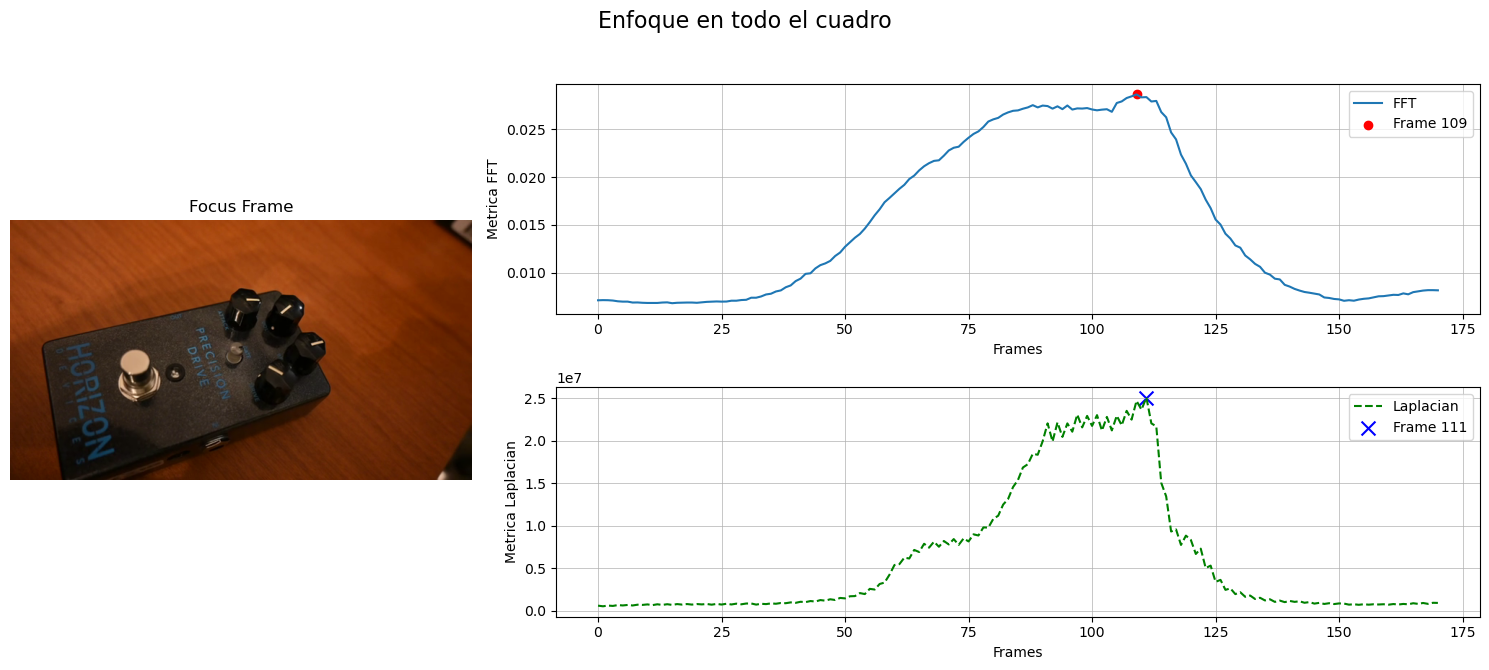

In [6]:
# Disposición de los gráficos
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 2])

# Frame de enfoque
ax1 = fig.add_subplot(gs[:, 0])
ax1.imshow(focus_frame_fft[..., ::-1])
ax1.set_title('Focus Frame')
ax1.axis('off')

# Graficar la métrica FFT y destacar el frame más nítido
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(sharpness_fft, label='FFT')
ax2.scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
ax2.set_xlabel('Frames')
ax2.set_ylabel('Metrica FFT')
ax2.legend()
ax2.grid(linewidth=0.5)

# Graficar la métrica Laplacian y destacar el frame más nítido
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(sharpness_lap, color='green', linestyle='--', linewidth=1.5, label='Laplacian')
ax3.scatter(frame_i_lap, frame_shp_lap, color='blue', marker='x', s=100, label=f'Frame {frame_i_lap}')
ax3.set_xlabel('Frames')
ax3.set_ylabel('Metrica Laplacian')
ax3.legend()
ax3.grid(linewidth=0.5)

# Archivo de salida
file_path = os.path.join(output_dir, 'focus.png')

# Ajustar título general y mostrar la figura
plt.suptitle('Enfoque en todo el cuadro', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(file_path, facecolor='white')
plt.show()


### Detección sobre una ROI 10%

In [7]:
percentage = 0.1
video_path = "focus_video.mov"

# Abrir el video y obtener frames
video = cv.VideoCapture(video_path)
n_frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))
frames = [obtener_frame(video, i) for i in range(n_frames)]

# Métrica: FFT.
sharpness_fft = sharpness_metric(frames, percentage=percentage)
frame_i_fft = sharpness_fft.index(max(sharpness_fft))
frame_shp_fft = sharpness_fft[frame_i_fft]
focus_frame_fft = frames[frame_i_fft]
in_focus_fft = [s >= frame_shp_fft * 0.9 for s in sharpness_fft]
frames_fft = [grafico_roi(frame.copy(), percentage, in_focus=in_focus) for frame, in_focus in zip(frames, in_focus_fft)]
file_name = f'focus_fft_roi_{percentage*100:.2g}%.mp4'
crear_video(frames_fft, file_name)

# Métrica: Laplacian. 
sharpness_lap = laplacian_sharpness_metric(frames, percentage=percentage)
frame_i_lap = sharpness_lap.index(max(sharpness_lap))
frame_shp_lap = sharpness_lap[frame_i_lap]
focus_frame_lap = frames[frame_i_lap]
in_focus_lap = [s >= frame_shp_lap * 0.9 for s in sharpness_lap]
frames_lap = [grafico_roi(frame.copy(), percentage, in_focus=in_focus) for frame, in_focus in zip(frames, in_focus_lap)]
file_name = f'focus_lap_roi_{percentage*100:.2g}%.mp4'
crear_video(frames_lap, file_name)

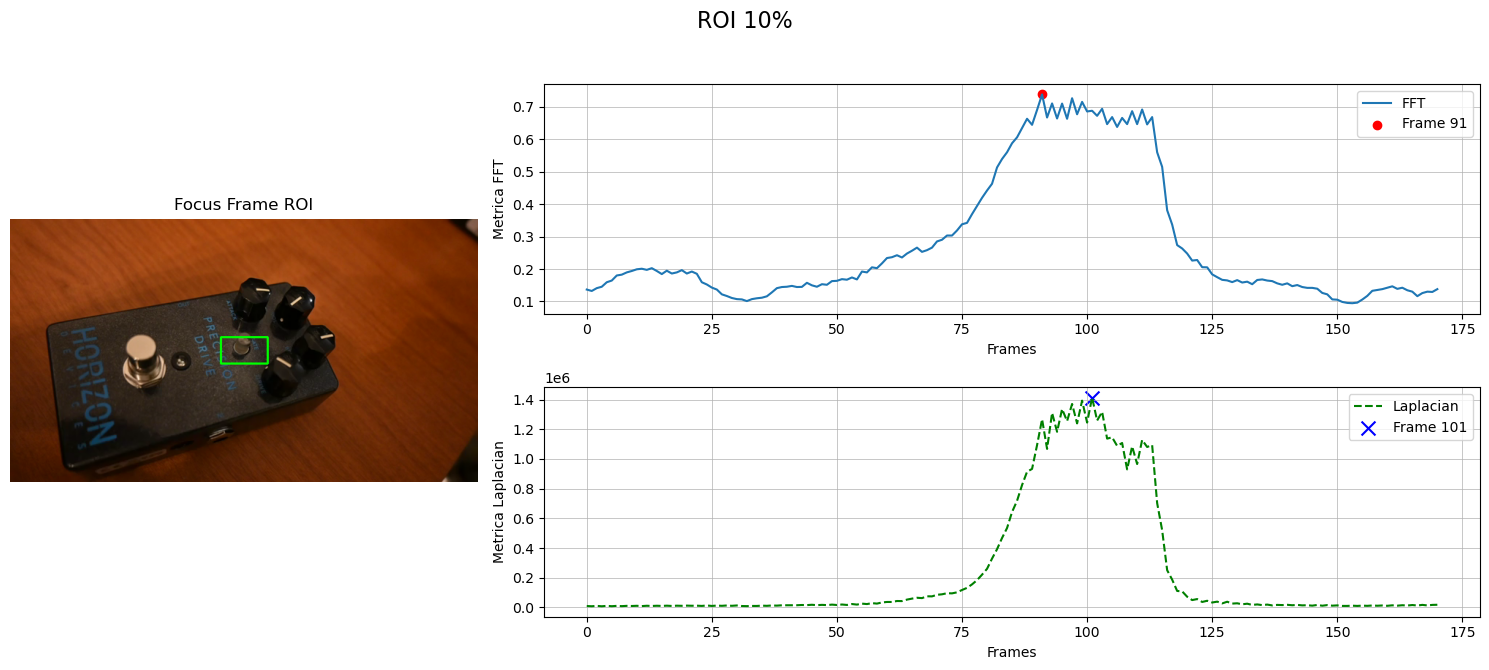

In [8]:
# Disposición de los gráficos
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 2])

# ROI de enfoque
ax1 = fig.add_subplot(gs[:, 0])
focus_frame_fft_cp = grafico_roi(focus_frame_fft.copy(), percentage, True)
ax1.imshow(focus_frame_fft_cp[..., ::-1])
ax1.set_title('Focus Frame ROI')
ax1.axis('off')

# Graficar la métrica FFT y destacar el frame más nítido
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(sharpness_fft, label='FFT')
ax2.scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
ax2.set_xlabel('Frames')
ax2.set_ylabel('Metrica FFT')
ax2.legend()
ax2.grid(linewidth=0.5)

# Graficar la métrica Laplacian y destacar el frame más nítido
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(sharpness_lap, color='green', linestyle='--', linewidth=1.5, label='Laplacian')  # Cambié el color y el estilo de línea
ax3.scatter(frame_i_lap, frame_shp_lap, color='blue', marker='x', s=100, label=f'Frame {frame_i_lap}')  # Cambié el color y el estilo del marcador del frame máximo
ax3.set_xlabel('Frames')
ax3.set_ylabel('Metrica Laplacian')
ax3.legend()
ax3.grid(linewidth=0.5)

# Archivo de salida
file_name = f'focus_roi_{percentage * 100:.2g}.png'.replace('%', '') 
file_path = os.path.join(output_dir, file_name)

# Ajustar título general y mostrar la figura
plt.suptitle(f'ROI {percentage*100:.2g}%', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(file_path, facecolor='white')
plt.show()



### Detección sobre una matriz de 3 x 3

In [9]:
#Funciones de matriz

# Obtener una matriz de regiones de la imagen
def obtener_matriz(frame, N=3, M=3, height=30, width=30, dy=30, dx=30):
    frame_h, frame_w = frame.shape[:2]
    margin_x, margin_y = (frame_w - (M * width + (M - 1) * dx)) // 2, (frame_h - (N * height + (N - 1) * dy)) // 2
    return [
        frame[margin_y + i * (height + dy):margin_y + i * (height + dy) + height, 
              margin_x + j * (width + dx):margin_x + j * (width + dx) + width]
        for i in range(N) for j in range(M)
    ]

# Dibujar una matriz de regiones en la imagen
def grafico_matriz(frame, N=3, M=3, height=30, width=30, dy=30, dx=30, in_focus=False):
    frame_cp = frame.copy()
    frame_h, frame_w = frame_cp.shape[:2]
    margin_x, margin_y = (frame_w - (M * width + (M - 1) * dx)) // 2, (frame_h - (N * height + (N - 1) * dy)) // 2
    color = (0, 255, 0) if in_focus else (0, 0, 255)

    for i in range(N):
        for j in range(M):
            x, y = margin_x + j * (width + dx), margin_y + i * (height + dy)
            cv.rectangle(frame_cp, (x, y), (x + width, y + height), color, 2)

    return frame_cp


# Calcular la métrica de nitidez sobre una matriz de regiones
def sharpness_metric_by_mor(frames, N=3, M=3, height=30, width=30, dy=30, dx=30, method="fft"):
    metrics = []
    for frame in frames:
        regions = obtener_matriz(frame, N, M, height, width, dy, dx)
        sharpness = sharpness_metric(regions) if method == "fft" else laplacian_sharpness_metric(regions)
        metrics.append(np.mean(sharpness))
    return metrics

In [10]:
N, M = 3, 3
video_path = "focus_video.mov"

# Abrir el video y obtener frames
video = cv.VideoCapture(video_path)
n_frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))
frames = [obtener_frame(video, i) for i in range(n_frames)]

# Métrica: FFT.
sharpness_fft = sharpness_metric_by_mor(frames, N=N, M=M)
frame_i_fft = sharpness_fft.index(max(sharpness_fft))
frame_shp_fft = sharpness_fft[frame_i_fft]
focus_frame_fft = frames[frame_i_fft]
in_focus_fft = [s >= frame_shp_fft * 0.9 for s in sharpness_fft]
frames_fft = [grafico_matriz(frame.copy(), N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames, in_focus_fft)]
file_name = f'focus_fft_mor_{N}x{M}.mp4'
crear_video(frames_fft, file_name)

# Métrica: Laplacian. 
sharpness_lap = sharpness_metric_by_mor(frames, N=N, M=M, method="laplacian")
frame_i_lap = sharpness_lap.index(max(sharpness_lap))
frame_shp_lap = sharpness_lap[frame_i_lap]
focus_frame_lap = frames[frame_i_lap]
in_focus_lap = [s >= frame_shp_lap * 0.9 for s in sharpness_lap]
frames_lap = [grafico_matriz(frame.copy(), N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames, in_focus_lap)]
file_name = f'focus_lap_mor_{N}x{M}.mp4'
crear_video(frames_lap, file_name)




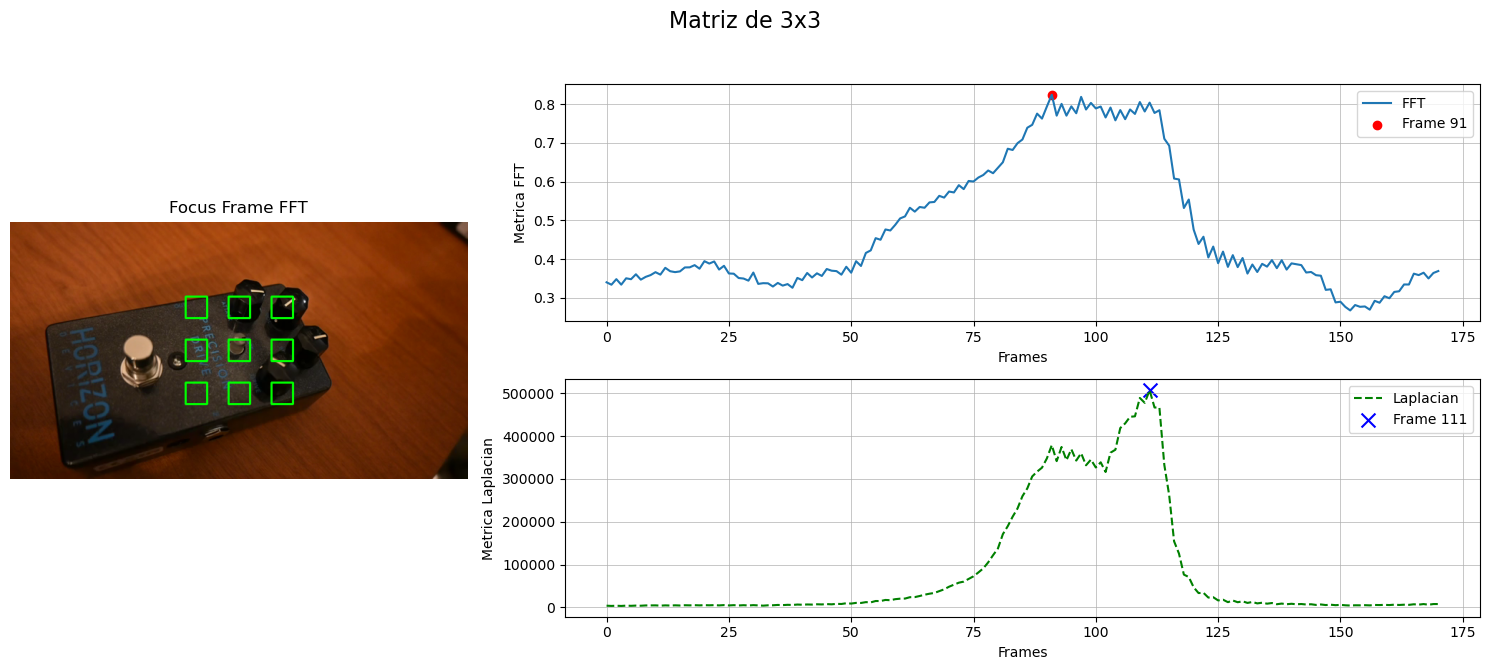

In [11]:
# Disposición de los gráficos
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 2])

# Matriz de enfoque
ax1 = fig.add_subplot(gs[:, 0])
focus_frame_fft_cp = grafico_matriz(focus_frame_fft.copy(), N=N, M=M, in_focus=True)
ax1.imshow(focus_frame_fft_cp[..., ::-1])
ax1.set_title('Focus Frame FFT')
ax1.axis('off')

# Graficar la métrica FFT y destacar el frame más nítido
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(sharpness_fft, label='FFT')
ax2.scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
ax2.set_xlabel('Frames')
ax2.set_ylabel('Metrica FFT')
ax2.legend()
ax2.grid(linewidth=0.5)

# Graficar la métrica Laplacian y destacar el frame más nítido
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(sharpness_lap, color='green', linestyle='--', linewidth=1.5, label='Laplacian')  # Cambié el color y el estilo de línea
ax3.scatter(frame_i_lap, frame_shp_lap, color='blue', marker='x', s=100, label=f'Frame {frame_i_lap}')  # Cambié el color y el estilo del marcador del frame máximo
ax3.set_xlabel('Frames')
ax3.set_ylabel('Metrica Laplacian')
ax3.legend()
ax3.grid(linewidth=0.5)

# Archivo de salida
file_name = f'focus_mor_{N}x{M}.png'
file_path = os.path.join(output_dir, file_name)

# Ajustar título general y mostrar la figura
plt.suptitle(f'Matriz de {N}x{M}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(file_path, facecolor='white')
plt.show()





### Detección sobre una matriz de 4 x 8

In [12]:
N, M = 4, 8
video_path = "focus_video.mov"

# Abrir el video y obtener frames
video = cv.VideoCapture(video_path)
n_frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))
frames = [obtener_frame(video, i) for i in range(n_frames)]

# Métrica: FFT.
sharpness_fft = sharpness_metric_by_mor(frames, N=N, M=M)
frame_i_fft = sharpness_fft.index(max(sharpness_fft))
frame_shp_fft = sharpness_fft[frame_i_fft]
focus_frame_fft = frames[frame_i_fft]
in_focus_fft = [s >= frame_shp_fft * 0.9 for s in sharpness_fft]
frames_fft = [grafico_matriz(frame.copy(), N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames, in_focus_fft)]
file_name = f'focus_fft_mor_{N}x{M}.mp4'
crear_video(frames_fft, file_name)

# Métrica: Laplacian.
sharpness_lap = sharpness_metric_by_mor(frames, N=N, M=M, method="laplacian")
frame_i_lap = sharpness_lap.index(max(sharpness_lap))
frame_shp_lap = sharpness_lap[frame_i_lap]
focus_frame_lap = frames[frame_i_lap]
in_focus_lap = [s >= frame_shp_lap * 0.9 for s in sharpness_lap]
frames_lap = [grafico_matriz(frame.copy(), N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames, in_focus_lap)]
file_name = f'focus_lap_mor_{N}x{M}.mp4'
crear_video(frames_lap, file_name)

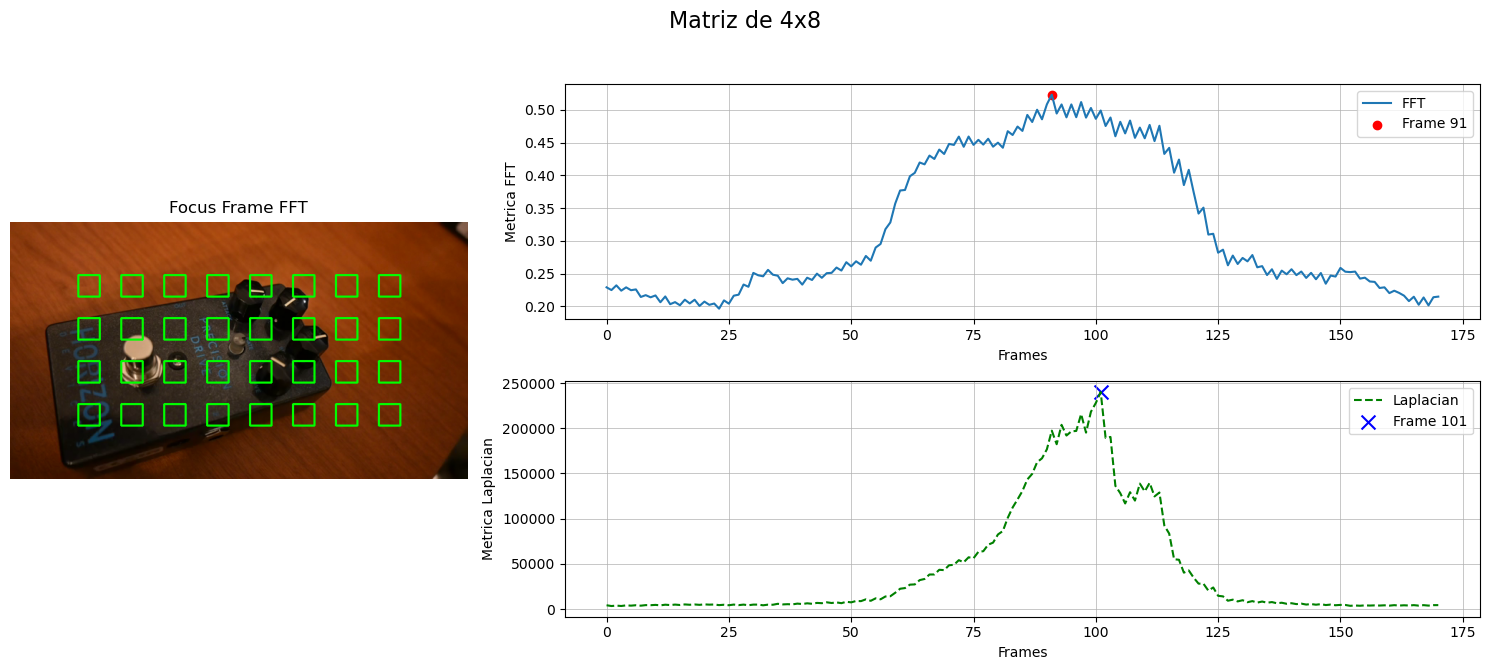

In [13]:
# Disposición de los gráficos
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 2])

# Matriz de enfoque
ax1 = fig.add_subplot(gs[:, 0])
focus_frame_fft_cp = grafico_matriz(focus_frame_fft.copy(), N=N, M=M, in_focus=True)
ax1.imshow(focus_frame_fft_cp[..., ::-1])
ax1.set_title('Focus Frame FFT')
ax1.axis('off')

# Graficar la métrica FFT y destacar el frame más nítido
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(sharpness_fft, label='FFT')
ax2.scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
ax2.set_xlabel('Frames')
ax2.set_ylabel('Metrica FFT')
ax2.legend()
ax2.grid(linewidth=0.5)

# Graficar la métrica Laplacian y destacar el frame más nítido
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(sharpness_lap, color='green', linestyle='--', linewidth=1.5, label='Laplacian')  # Cambié el color y el estilo de línea
ax3.scatter(frame_i_lap, frame_shp_lap, color='blue', marker='x', s=100, label=f'Frame {frame_i_lap}')  # Cambié el color y el estilo del marcador del frame máximo
ax3.set_xlabel('Frames')
ax3.set_ylabel('Metrica Laplacian')
ax3.legend()
ax3.grid(linewidth=0.5)

# Archivo de salida
file_name = f'focus_mor_{N}x{M}.png'
file_path = os.path.join(output_dir, file_name)

# Ajustar título general y mostrar la figura
plt.suptitle(f'Matriz de {N}x{M}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(file_path, facecolor='white')
plt.show()


### Detección sobre una matriz de 6 x 10

In [14]:
N, M = 6, 10
video_path = "focus_video.mov"

# Abrir el video y obtener frames
video = cv.VideoCapture(video_path)
n_frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))
frames = [obtener_frame(video, i) for i in range(n_frames)]

# Métrica: FFT. 
sharpness_fft = sharpness_metric_by_mor(frames, N=N, M=M)
frame_i_fft = sharpness_fft.index(max(sharpness_fft))
frame_shp_fft = sharpness_fft[frame_i_fft]
focus_frame_fft = frames[frame_i_fft]
in_focus_fft = [s >= frame_shp_fft * 0.9 for s in sharpness_fft]
frames_fft = [grafico_matriz(frame.copy(), N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames, in_focus_fft)]
file_name = f'focus_fft_mor_{N}x{M}.mp4'
crear_video(frames_fft, file_name)

# Métrica: Laplacian.
sharpness_lap = sharpness_metric_by_mor(frames, N=N, M=M, method="laplacian")
frame_i_lap = sharpness_lap.index(max(sharpness_lap))
frame_shp_lap = sharpness_lap[frame_i_lap]
focus_frame_lap = frames[frame_i_lap]
in_focus_lap = [s >= frame_shp_lap * 0.9 for s in sharpness_lap]
frames_lap = [grafico_matriz(frame.copy(), N=N, M=M, in_focus=is_in_focus) for frame, is_in_focus in zip(frames, in_focus_lap)]
file_name = f'focus_lap_mor_{N}x{M}.mp4'
crear_video(frames_lap, file_name)



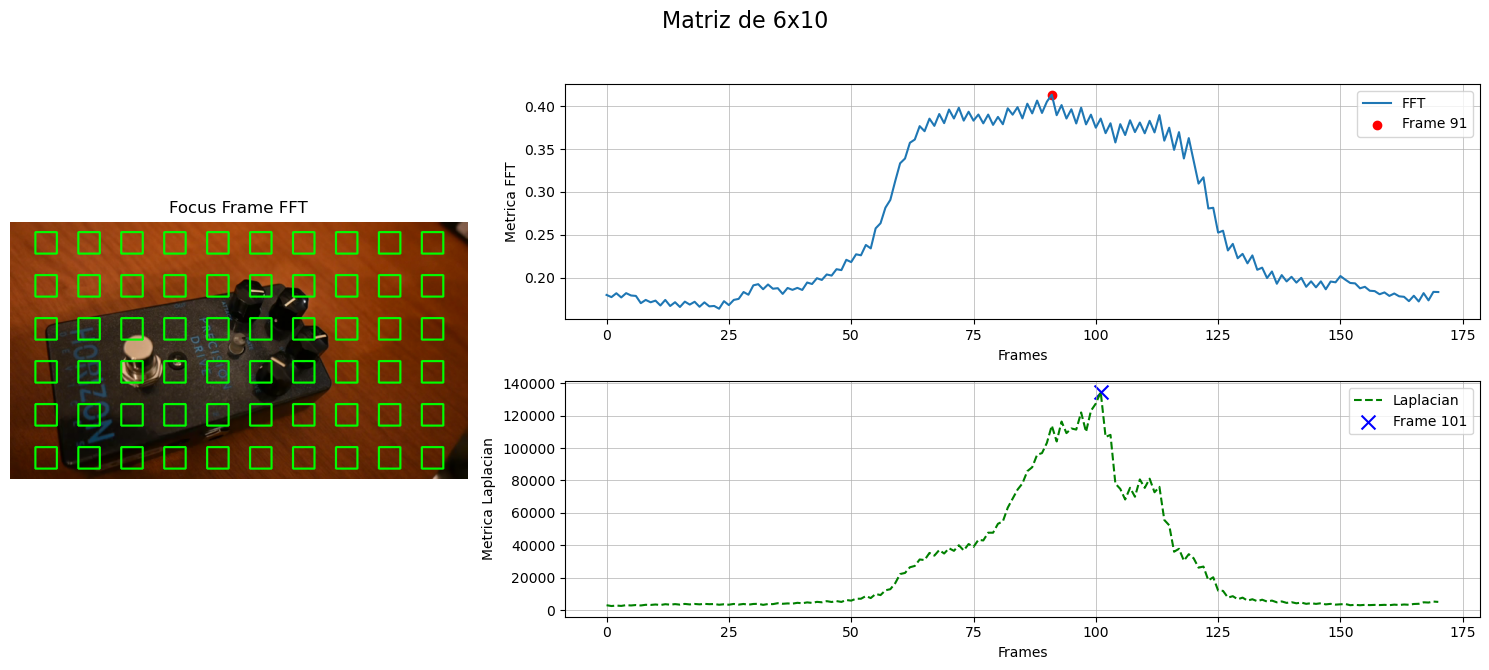

In [15]:
# Disposición de los gráficos
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 2])

# Matriz de enfoque
ax1 = fig.add_subplot(gs[:, 0])
focus_frame_fft_cp = grafico_matriz(focus_frame_fft.copy(), N=N, M=M, in_focus=True)
ax1.imshow(focus_frame_fft_cp[..., ::-1])
ax1.set_title('Focus Frame FFT')
ax1.axis('off')

# Graficar la métrica FFT y destacar el frame más nítido
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(sharpness_fft, label='FFT')
ax2.scatter(frame_i_fft, frame_shp_fft, color='red', label=f'Frame {frame_i_fft}')
ax2.set_xlabel('Frames')
ax2.set_ylabel('Metrica FFT')
ax2.legend()
ax2.grid(linewidth=0.5)

# Graficar la métrica Laplacian y destacar el frame más nítido
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(sharpness_lap, color='green', linestyle='--', linewidth=1.5, label='Laplacian')  # Cambié el color y el estilo de línea
ax3.scatter(frame_i_lap, frame_shp_lap, color='blue', marker='x', s=100, label=f'Frame {frame_i_lap}')  # Cambié el color y el estilo del marcador del frame máximo
ax3.set_xlabel('Frames')
ax3.set_ylabel('Metrica Laplacian')
ax3.legend()
ax3.grid(linewidth=0.5)

# Archivo de salida
file_name = f'focus_mor_{N}x{M}.png'
file_path = os.path.join(output_dir, file_name)

# Ajustar título general y mostrar la figura
plt.suptitle(f'Matriz de {N}x{M}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(file_path, facecolor='white')
plt.show()


Se realizaron multiples experimentos basado en diferentes matrices. Comparativamente el metodo basado en frecuencias fue siempre mas consistente al detectar el el punto de maximo enfoque (Frame: 91)